# Solving MAXCUT Using QAOA in `qiskit`

Max-Cut is an NP-complete problem, with applications in clustering, network science, and statistical physics. To grasp how practical applications are mapped into given Max-Cut instances, consider a system of many people that can interact and influence each other. Individuals can be represented by vertices of a graph, and their interactions seen as pairwise connections between vertices of the graph, or edges. With this representation in mind, it is easy to model typical marketing problems. For example, suppose that it is assumed that individuals will influence each other’s buying decisions, and knowledge is given about how strong they will influence each other. The influence can be modeled by weights assigned on each edge of the graph. It is possible then to predict the outcome of a marketing strategy in which products are offered for free to some individuals, and then ask which is the optimal subset of individuals that should get the free products, in order to maximize revenues.



Consider an $n$-node undirected graph $G = (V, E)$ where $|V| = n$ with edge weights $w_{ij} \geq 0$, $w_{ij} = w_{ji}$ for $(i, j) \in E$. A cut is defined as a partition of the original set $V$ into two subsets. The cost function to be optimized is in this case the sum of weights of edges connecting points in the two different subsets, crossing the cut.

In [27]:
import matplotlib.pyplot as plt
import matplotlib.axes as axes
%matplotlib inline
import numpy as np
import json
import networkx as nx
import seaborn as sns

# useful additional packages
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import numpy as np
import networkx as nx

from qiskit import Aer
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA
from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.problems import QuadraticProgram

sns.set_theme()


In [28]:
import qiskit
qiskit.__version__

'0.21.2'

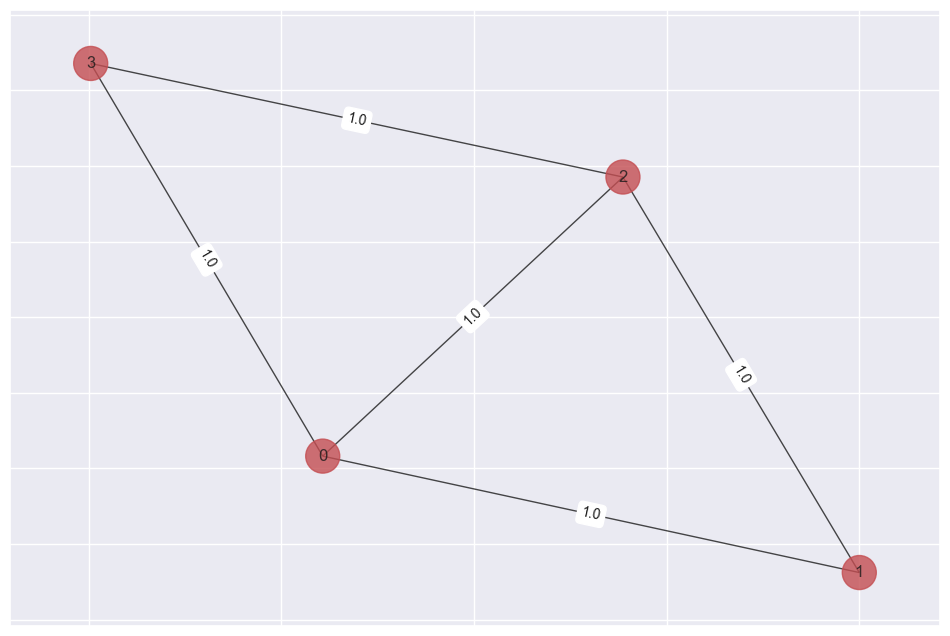

In [29]:
# Generating a graph of 4 nodes

n=4 # Number of nodes in graph
G=nx.Graph()
G.add_nodes_from(np.arange(0,n,1))
elist=[(0,1,1.0),(0,2,1.0),(0,3,1.0),(1,2,1.0),(2,3,1.0)]
# tuple is (i,j,weight) where (i,j) is the edge
G.add_weighted_edges_from(elist)

colors = ['r' for node in G.nodes()]
pos = nx.spring_layout(G)

def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

draw_graph(G, colors, pos)

In [30]:
# Computing the weight matrix from the random graph
w = np.zeros([n,n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i,j,default=0)
        if temp != 0:
            w[i,j] = temp['weight']
print(w)

[[0. 1. 1. 1.]
 [1. 0. 1. 0.]
 [1. 1. 0. 1.]
 [1. 0. 1. 0.]]


case = [0, 0, 0, 0] cost = 0.0
case = [1, 0, 0, 0] cost = 3.0
case = [0, 1, 0, 0] cost = 2.0
case = [1, 1, 0, 0] cost = 3.0
case = [0, 0, 1, 0] cost = 3.0
case = [1, 0, 1, 0] cost = 4.0
case = [0, 1, 1, 0] cost = 3.0
case = [1, 1, 1, 0] cost = 2.0
case = [0, 0, 0, 1] cost = 2.0
case = [1, 0, 0, 1] cost = 3.0
case = [0, 1, 0, 1] cost = 4.0
case = [1, 1, 0, 1] cost = 3.0
case = [0, 0, 1, 1] cost = 3.0
case = [1, 0, 1, 1] cost = 2.0
case = [0, 1, 1, 1] cost = 3.0
case = [1, 1, 1, 1] cost = 0.0

Best solution = [1, 0, 1, 0] cost = 4.0


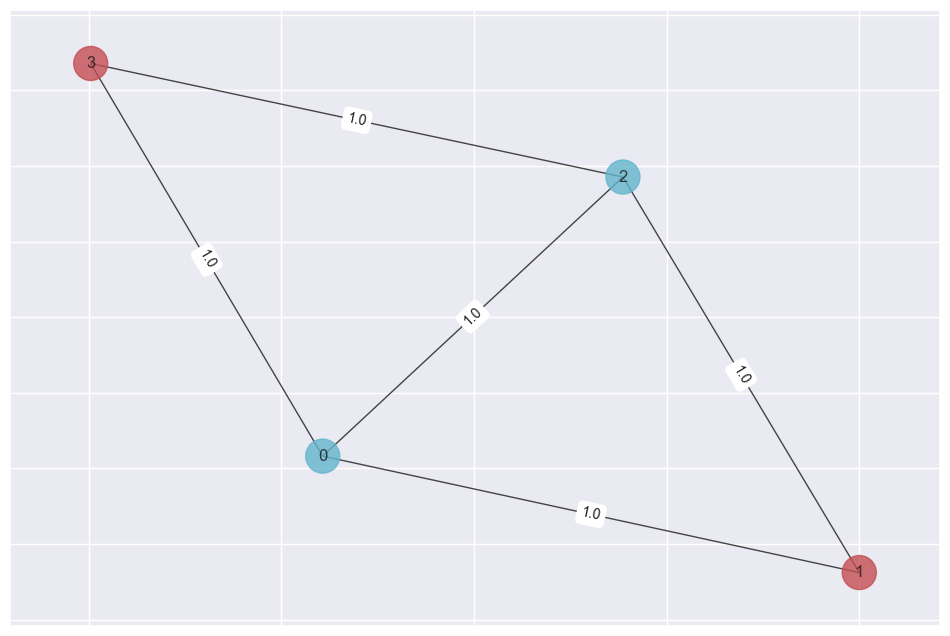

In [31]:
best_cost_brute = 0
for b in range(2**n):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
    cost = 0
    for i in range(n):
        for j in range(n):
            cost = cost + w[i,j]*x[i]*(1-x[j])
    if best_cost_brute < cost:
        best_cost_brute = cost
        xbest_brute = x
    print('case = ' + str(x)+ ' cost = ' + str(cost))

colors = ['r' if xbest_brute[i] == 0 else 'c' for i in range(n)]
draw_graph(G, colors, pos)
print('\nBest solution = ' + str(xbest_brute) + ' cost = ' + str(best_cost_brute))

In [32]:
max_cut = Maxcut(w)
qp = max_cut.to_quadratic_program()
print(qp.prettyprint())

Problem name: Max-cut

Maximize
  -2*x_0*x_1 - 2*x_0*x_2 - 2*x_0*x_3 - 2*x_1*x_2 - 2*x_2*x_3 + 3*x_0 + 2*x_1
  + 3*x_2 + 2*x_3

Subject to
  No constraints

  Binary variables (4)
    x_0 x_1 x_2 x_3



In [33]:
qubitOp, offset = qp.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Offset: -2.5
Ising Hamiltonian:
0.5 * IIZZ
+ 0.5 * IZIZ
+ 0.5 * IZZI
+ 0.5 * ZIIZ
+ 0.5 * ZZII


In [34]:
# solving Quadratic Program using exact classical eigensolver
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result = exact.solve(qp)
print(result.prettyprint())

objective function value: 4.0
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0
status: SUCCESS


### Check that the full Hamiltonian gives the right cost

energy: -1.5
max-cut objective: -4.0
solution: [1 0 1 0]
solution objective: 4.0


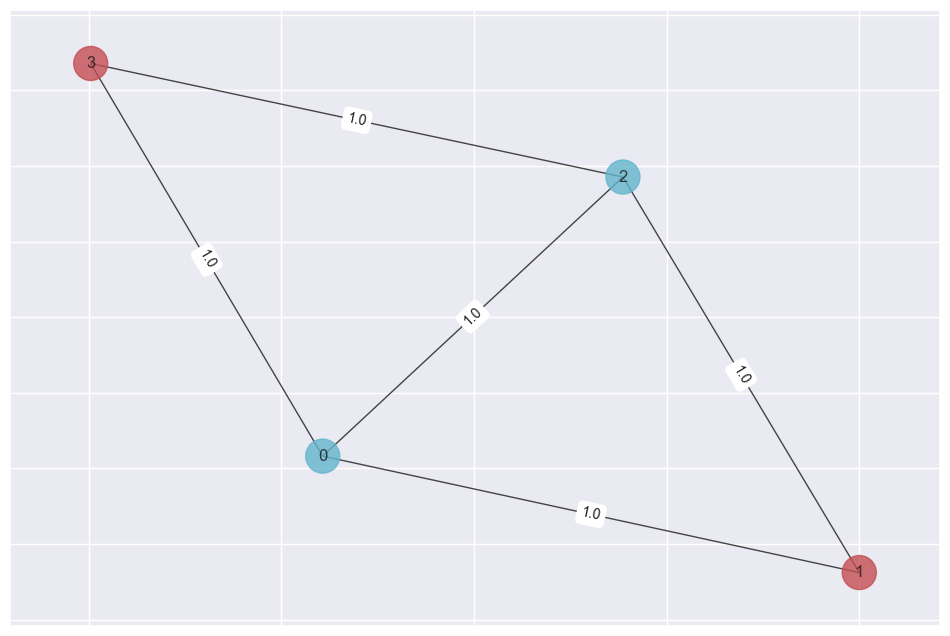

In [35]:
ee = NumPyMinimumEigensolver()

# Calculate the min eigenvalue
result = ee.compute_minimum_eigenvalue(qubitOp)

x = max_cut.sample_most_likely(result.eigenstate)
print('energy:', result.eigenvalue.real)
print('max-cut objective:', result.eigenvalue.real + offset)
print('solution:', x)
print('solution objective:', qp.objective.evaluate(x))

colors = ["r" if x[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)

# Setting the parameters for the run

- `p_max` - The numbers of layers for the p
- `optimizer` -- The Optimization technique to use for the local optimizer. We'll use a default optimzation algorithm of COBYLA (it has decent performance but also is fast)
- `Initialisation` -- this is an Initialisation object that parameterises the initialiasation technique being used. For this run we're using a `random` appraoch to initial parameters

Running it on quantum computer
We run the optimization routine using a feedback loop with a quantum computer that uses trial functions built with Y single-qubit rotations, $U_\mathrm{single}(\theta) = \prod_{i=1}^n Y(\theta_{i})$, and entangler steps $U_{entangler}$.

In [36]:
algorithm_globals.random_seed = 12321
seed = 10598
backend = Aer.get_backend("aer_simulator_statevector")
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)

energy: -1.4997512539998312
time: 1.376570224761963
max-cut objective: -3.9997512539998312
solution: [1. 0. 1. 0.]
solution objective: 4.0


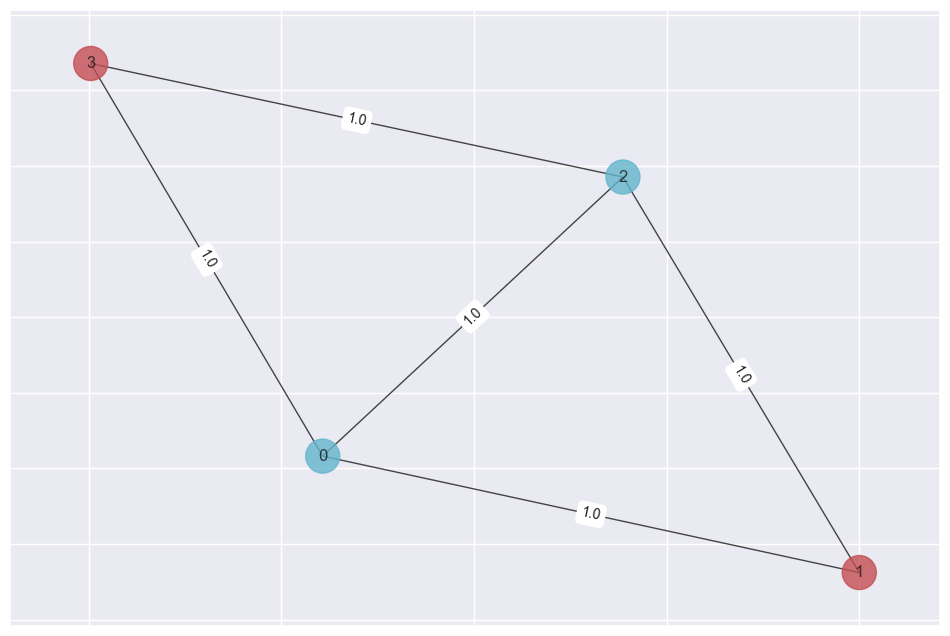

In [38]:
spsa = SPSA(maxiter=300)
ry = TwoLocal(qubitOp.num_qubits, "ry", "cz", reps=5, entanglement="linear")
vqe = VQE(ry, optimizer=spsa, quantum_instance=quantum_instance)

# run VQE
result = vqe.compute_minimum_eigenvalue(qubitOp)

# print results
x = max_cut.sample_most_likely(result.eigenstate)
print("energy:", result.eigenvalue.real)
print("time:", result.optimizer_time)
print("max-cut objective:", result.eigenvalue.real + offset)
print("solution:", x)
print("solution objective:", qp.objective.evaluate(x))

# plot results
colors = ["r" if x[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)

In [39]:
result

objective function value: 4.0
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0
status: SUCCESS


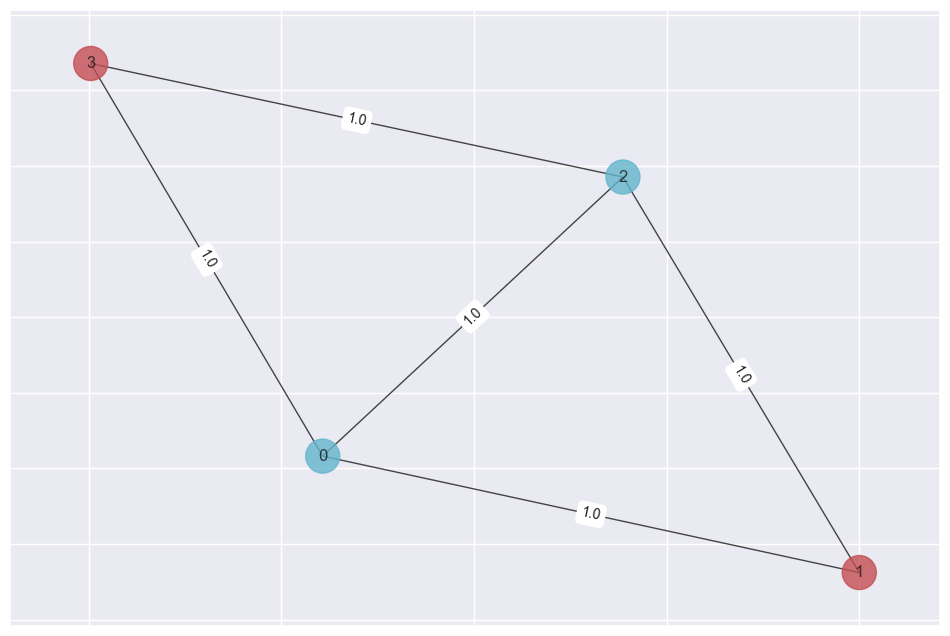

In [40]:
# create minimum eigen optimizer based on VQE
vqe_optimizer = MinimumEigenOptimizer(vqe)

# solve quadratic program
result = vqe_optimizer.solve(qp)
print(result.prettyprint())

colors = ["r" if result.x[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)

# Compare Optimization Problems

energy: -1.4980731398008311
time: 1.035531997680664
max-cut objective: -3.998073139800831
solution: [1. 0. 1. 0.]
solution objective: 4.0


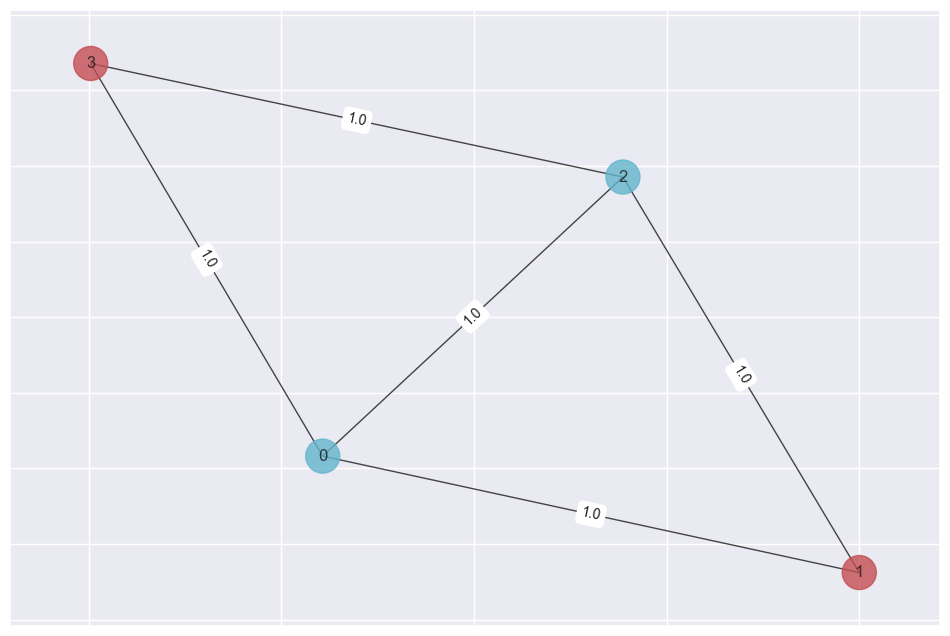

In [41]:
spsa = SPSA(maxiter=300)
ry = TwoLocal(qubitOp.num_qubits, "ry", "cz", reps=2, entanglement="linear")
vqe = VQE(ry, optimizer=spsa, quantum_instance=quantum_instance)

# run VQE
result = vqe.compute_minimum_eigenvalue(qubitOp)

# print results
x = max_cut.sample_most_likely(result.eigenstate)
print("energy:", result.eigenvalue.real)
print("time:", result.optimizer_time)
print("max-cut objective:", result.eigenvalue.real + offset)
print("solution:", x)
print("solution objective:", qp.objective.evaluate(x))

# plot results
colors = ["r" if x[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)

In [42]:
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP, SPSA, NELDER_MEAD

optimizers = [COBYLA, SPSA, NELDER_MEAD]
converge_cnts = np.empty([len(optimizers)], dtype=object)
converge_vals = np.empty([len(optimizers)], dtype=object)
num_qubits = qubitOp.num_qubits

In [43]:
init_state = np.random.rand(4)*2*np.pi
print(f"The initial state is {init_state}")

n_restarts = 1

for i in range(len(optimizers)):
    optimizer = optimizers[i]()
    print(f'Testing Optimizer {i+1}: {type(optimizer).__name__}')

    counts = []
    values = []
    
    # Callback definition
    def store_intermediate_result(eval_count, parameters, mean, std):
        if eval_count % 100 == 0:
            print(f"{type(optimizer).__name__} iteration {eval_count} \t cost function {mean}")
        counts.append(eval_count)
        values.append(mean)
    
    for restart in range(n_restarts):
        print(restart)
        init_state = np.random.rand(4)*2*np.pi

        # Define the systems of rotation for x and y
        ry = TwoLocal(num_qubits, "ry", "cz", reps=2, entanglement="linear")
        
        # VQE definition
        vqe = VQE(ry, optimizer=optimizer, quantum_instance=quantum_instance, callback=store_intermediate_result)
        algo_result = vqe.compute_minimum_eigenvalue(qubitOp)
    
    # Convergence array
    total_counts = np.arange(0, len(counts))
    converge_cnts[i] = total_counts
    converge_vals[i] = np.asarray(values)

The initial state is [2.36721582 4.09234987 1.97482296 1.44338272]
Testing Optimizer 1: COBYLA
0
COBYLA iteration 100 	 cost function -1.498363785126318
COBYLA iteration 200 	 cost function -1.499852569933134
COBYLA iteration 300 	 cost function -1.4999026077322206
COBYLA iteration 400 	 cost function -1.4999354235968034
COBYLA iteration 500 	 cost function -1.4999537077133844
COBYLA iteration 600 	 cost function -1.49996770943965
COBYLA iteration 700 	 cost function -1.4999784042828044
COBYLA iteration 800 	 cost function -1.4999843357330764
COBYLA iteration 900 	 cost function -1.4999883724543996
COBYLA iteration 1000 	 cost function -1.499991285369584
Testing Optimizer 2: SPSA
0
SPSA iteration 100 	 cost function -1.289485234793038
SPSA iteration 200 	 cost function -1.481436598238386
Testing Optimizer 3: NELDER_MEAD
0
NELDER_MEAD iteration 100 	 cost function -1.1492124349752733
NELDER_MEAD iteration 200 	 cost function -1.4950033225257888
NELDER_MEAD iteration 300 	 cost function 

In [44]:
len(converge_cnts[0]) == len(converge_vals[0])

True

In [45]:
import pylab

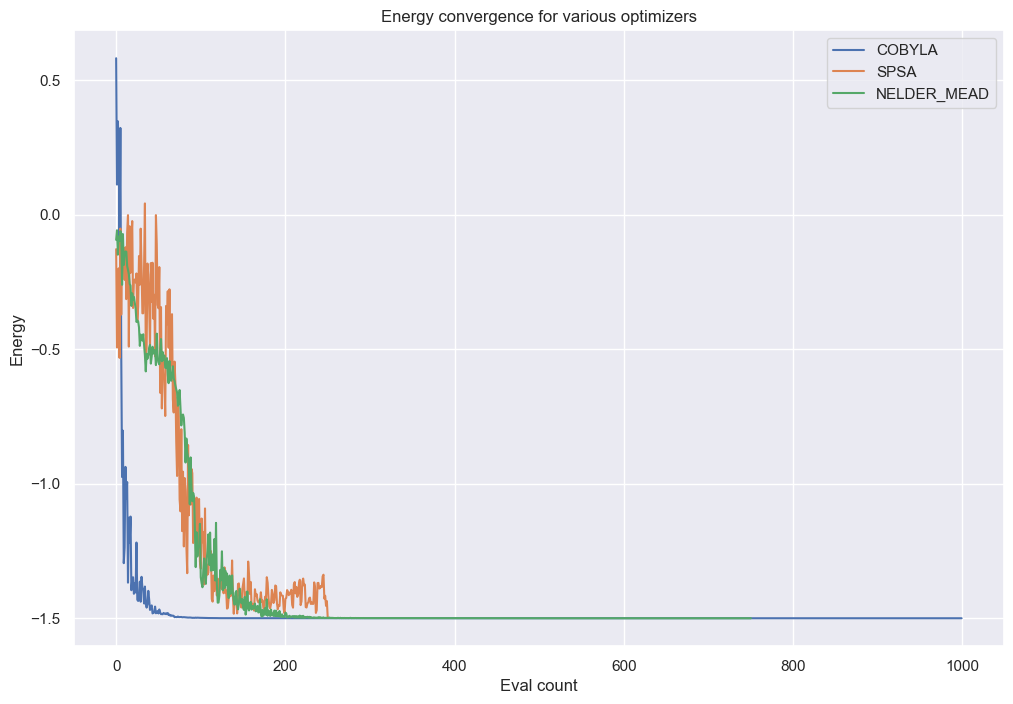

In [46]:
pylab.rcParams['figure.figsize'] = (12, 8)
for i in range(len(optimizers)):
    pylab.plot(converge_cnts[i], converge_vals[i], label=optimizers[i].__name__)
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('Energy convergence for various optimizers')
pylab.legend(loc='upper right')

# Random restarts



In [47]:

print(f"The initial state is {init_state}")

n_restarts = 5

for i in range(len(optimizers)):
    optimizer = optimizers[i]()
    print(f'Testing Optimizer {i+1}: {type(optimizer).__name__}')

    counts = []
    values = []
    
    # Callback definition
    def store_intermediate_result(eval_count, parameters, mean, std):
        if eval_count % 100 == 0:
            print(f"{type(optimizer).__name__} iteration {eval_count} \t cost function {mean}")
        counts.append(eval_count)
        values.append(mean)
    
    for restart in range(n_restarts):
        print(restart)
        init_state = np.random.rand(4)*2*np.pi

        # Define the systems of rotation for x and y
        ry = TwoLocal(num_qubits, "ry", "cz", reps=2, entanglement="linear")
        
        # VQE definition
        vqe = VQE(ry, optimizer=optimizer, quantum_instance=quantum_instance, callback=store_intermediate_result)
        algo_result = vqe.compute_minimum_eigenvalue(qubitOp)
    
    # Convergence array
    total_counts = np.arange(0, len(counts))
    converge_cnts[i] = total_counts
    converge_vals[i] = np.asarray(values)

The initial state is [2.48359515 0.72225278 0.5037717  5.88406871]
Testing Optimizer 1: COBYLA
0
COBYLA iteration 100 	 cost function -1.4985819378219103
COBYLA iteration 200 	 cost function -1.4998838483553356
COBYLA iteration 300 	 cost function -1.4999897462526892
COBYLA iteration 400 	 cost function -1.4999989657051551
1
COBYLA iteration 100 	 cost function -1.497282087127675
COBYLA iteration 200 	 cost function -1.4996897938341636
COBYLA iteration 300 	 cost function -1.4999711229853634
COBYLA iteration 400 	 cost function -1.499998030250809
COBYLA iteration 500 	 cost function -1.4999997729574577
2
COBYLA iteration 100 	 cost function -1.4985101415297253
COBYLA iteration 200 	 cost function -1.4999994793148133
3
COBYLA iteration 100 	 cost function -1.4991850255394472
COBYLA iteration 200 	 cost function -1.499992027052619
COBYLA iteration 300 	 cost function -1.4999999801508788
4
COBYLA iteration 100 	 cost function -1.4996515598755689
COBYLA iteration 200 	 cost function -1.499

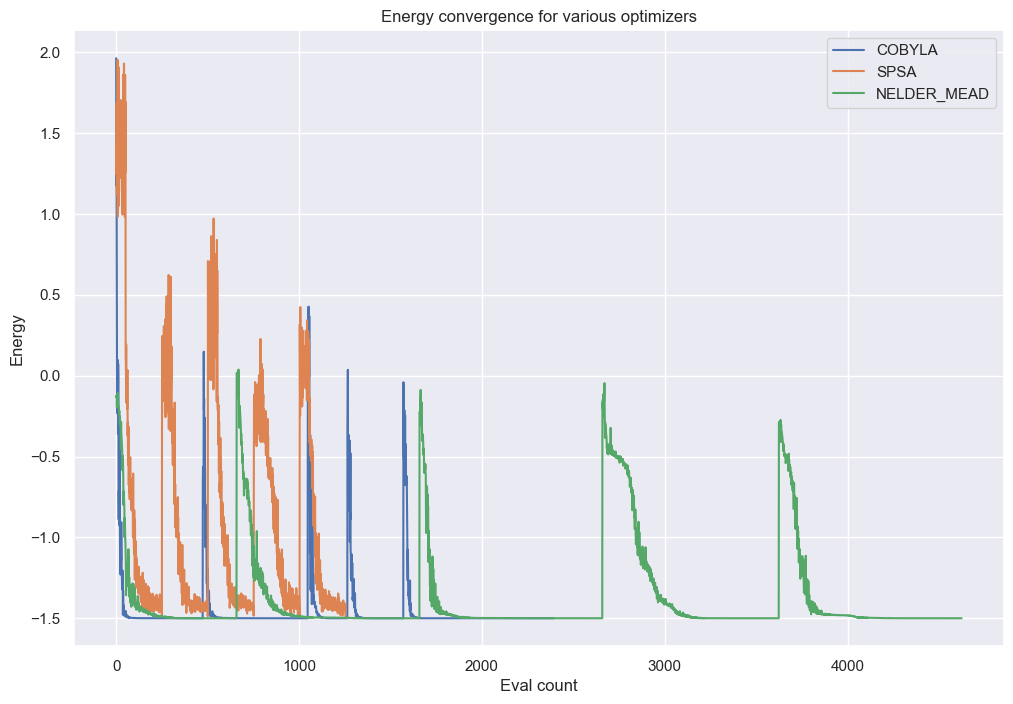

In [48]:
pylab.rcParams['figure.figsize'] = (12, 8)
for i in range(len(optimizers)):
    pylab.plot(converge_cnts[i], converge_vals[i], label=optimizers[i].__name__)
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('Energy convergence for various optimizers')
pylab.legend(loc='upper right')

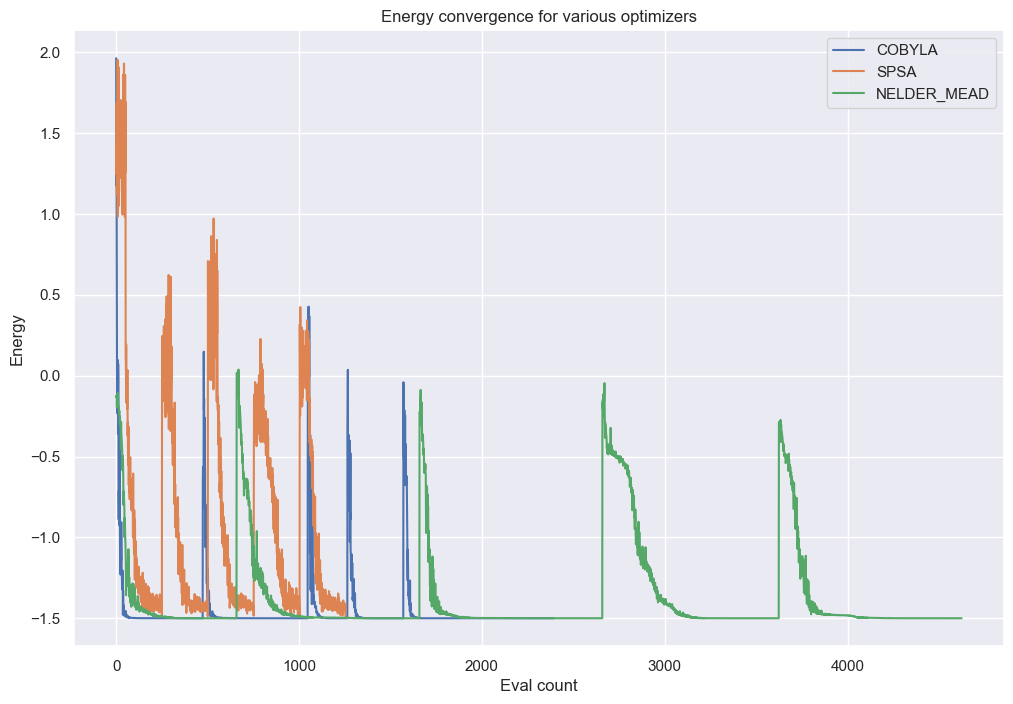

In [49]:
pylab.rcParams['figure.figsize'] = (12, 8)
for i in range(len(optimizers)):
    pylab.plot(converge_cnts[i], converge_vals[i], label=optimizers[i].__name__)
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('Energy convergence for various optimizers')
pylab.legend(loc='upper right')

In [52]:
import qiskit.tools.jupyter

%qiskit_version_table